In [1]:
import numpy as np
import sys
sys.path.append('/home/ec2-user/cfl')
from cfl.experiment import Experiment
from cfl.visualization_methods.basic_visualizations import visualize_macrostates
import visual_bars.generate_visual_bars_data as vbd
from sklearn.model_selection import train_test_split
import tensorflow as tf


In [2]:
def create_and_train_CFL_experiment(X, Y, in_sample_idx=None, out_sample_idx=None):
    ''' Helper function that will create a CFL experiment and train it for
        this demo.
    '''

    # set up pipeline parameters
    data_info = {'X_dims' : X.shape, 'Y_dims' : Y.shape, 'Y_type' : 'continuous'}
    CDE_params = { 
                'model'       : 'CondExpMod',
                'batch_size'  : 121,
                'optimizer'   : 'adam',
                'n_epochs'    : 30,
                'verbose'     : True,
                'dense_units' : [142, data_info['Y_dims'][1]],
                'activations' : ['linear', 'linear'],
                'dropouts'    : [0.12, 0.0],
                'weights_path' : 'sample_run/experiment0000/trained_blocks/CDE'
    }
    cause_cluster_params =  {'model' : 'KMeans', 'n_clusters' : 4, 'verbose' : 0, 'tune' : False}

    block_names = ['CDE', 'CauseClusterer']
    block_params = [CDE_params, cause_cluster_params]
    save_path = 'sample_run'

    # Create a new CFL experiment with specified parameters
    my_exp = Experiment(X_train=X, Y_train=Y, in_sample_idx=in_sample_idx,
                        out_sample_idx=out_sample_idx, data_info=data_info, 
                        block_names=block_names, block_params=block_params, 
                        results_path=save_path, verbose=0)
    results = my_exp.train()
    return my_exp, results

In [3]:
# create visual bars data 
n_samples = 20000 
im_shape = (10, 10) 
noise_lvl= 0.03
random_state = 180

vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape=im_shape, 
                             noise_lvl=noise_lvl, set_random_seed=random_state)

# retrieve the images and the target 
X = vb_data.getImages()
X = np.reshape(X, (X.shape[0], np.product(X.shape[1:]))) # flatten images
Y = vb_data.getTarget()
Y = np.expand_dims(Y, -1)
print(X.shape)
print(Y.shape)

# define train and validation sets to remain constant across tuning
in_sample_idx, out_sample_idx = train_test_split(range(X.shape[0]),
                                                 train_size=0.75,
                                                 random_state=42)
in_sample_idx = np.array(in_sample_idx)
out_sample_idx = np.array(out_sample_idx)                                                

(20000, 100)
(20000, 1)


In [4]:
my_exp,results = create_and_train_CFL_experiment(X, Y,in_sample_idx=in_sample_idx, 
                                          out_sample_idx=out_sample_idx)                                    

opt_config not specified in input, defaulting to {}
loss not specified in input, defaulting to mean_squared_error
show_plot not specified in input, defaulting to True
standardize not specified in input, defaulting to False
best not specified in input, defaulting to True
tb_path not specified in input, defaulting to None
optuna_callback not specified in input, defaulting to None
optuna_trial not specified in input, defaulting to None
early_stopping not specified in input, defaulting to False


2021-10-29 23:58:59.776191: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-29 23:58:59.832320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 23:58:59.833277: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla V100-SXM2-16GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:00:1e.0
2021-10-29 23:58:59.833511: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-10-29 23:58:59.834847: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-10-29 23:58:59.835977: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcu

Loading parameters from  sample_run/experiment0000/trained_blocks/CDE
Model has already been trained, will return predictions on                 training data.


2021-10-29 23:59:00.829022: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0


Saving parameters to  sample_run/experiment0011/trained_blocks/CDE


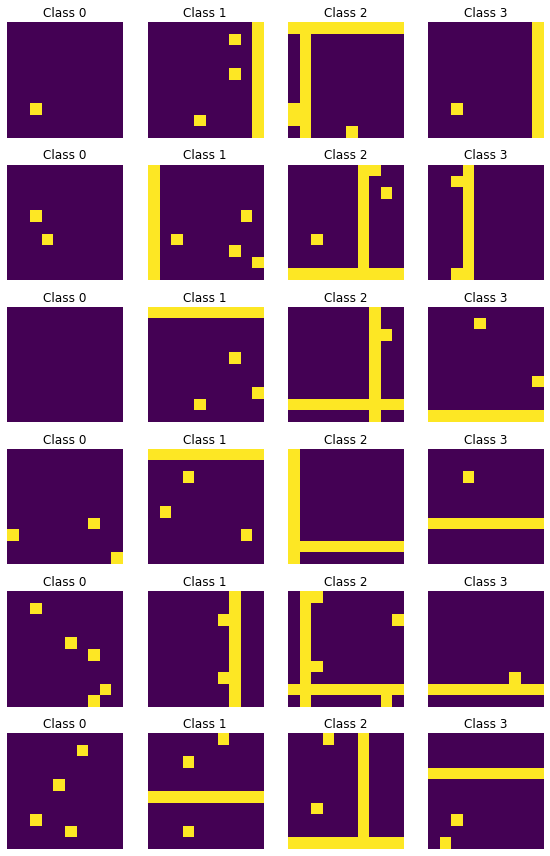

In [5]:
import cfl.visualization_methods.visual_bars_vis as vis

vis.viewImagesAndLabels(X, im_shape=im_shape, n_examples=6, 
                        x_lbls=results['CauseClusterer']['x_lbls'])

In [6]:
xlbls = results['CauseClusterer']['x_lbls']

In [7]:
# make ms_zero dataset
subidx = np.random.choice(np.where(xlbls==1)[0], 1000, replace=False)
zero_samples = X[subidx]
zero_samples = np.vstack([zero_samples]*5)
zero_samples.shape

(5000, 100)

In [8]:
# make ms_one dataset
subidx = np.random.choice(np.where(xlbls==2)[0], 1000, replace=False)
idx = np.random.choice(subidx, 5000, replace=True)
one_samples = X[idx]
one_samples.shape

(5000, 100)

In [9]:
# make model
def build_model():
    arch = [tf.keras.layers.Input(shape=(100,)),
            tf.keras.layers.Dense(units=16, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(units=16, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(units=16, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(units=16, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(units=100, activation='linear')]    
    model = tf.keras.models.Sequential(arch)
    return model

In [10]:
from cfl.dataset import Dataset
def my_loss_fxn(y_true, y_pred):
    # y_true = tf.make_ndarray(y_true)
    # y_pred = tf.make_ndarray(y_pred)
    # print('TEST', y_true.shape)
    y_true_dataset = Dataset(X=y_true, Y=None)
    y_pred_dataset = Dataset(X=y_pred, Y=None)
    true_ms = my_exp.predict(y_true_dataset)
    pred_ms = my_exp.predict(y_pred_dataset)
    print((true_ms==pred_ms).astype(np.float))
    return (true_ms==pred_ms).astype(np.float)

In [11]:
Xtr, Xva, Ytr, Yva = train_test_split(zero_samples, one_samples, train_size=0.75)
model = build_model()
        # optimizer = tf.keras.optimizers.get(
        #     { 'class_name' : self.params['optimizer'],
        #       'config' : self.params['opt_config']})
model.compile(loss=my_loss_fxn, 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
# train model
history = model.fit(
    Xtr, Ytr,
    batch_size=64,
    epochs=100,
    validation_data=(Xva,Yva),
    callbacks=None,
    verbose=1
)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ec2-user/miniconda/envs/cfl-gpu/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_24401/3109271335.py", line 7, in <module>
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
  File "/home/ec2-user/miniconda/envs/cfl-gpu/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/base.py", line 457, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/home/ec2-user/miniconda/envs/cfl-gpu/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training.py", line 373, in compile
    self._compile_weights_loss_and_weighted_metrics()
  File "/home/ec2-user/miniconda/envs/cfl-gpu/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/base.py", line 457, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/home/ec2-user/miniconda/envs/cfl-gpu/lib/python3.7/s

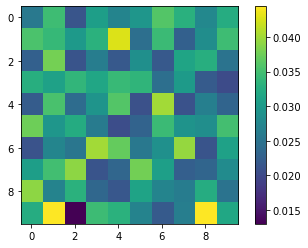

In [ ]:
import matplotlib.pyplot as plt
random_sample = np.zeros((1,100))
pred = model.predict(random_sample)
plt.imshow(np.reshape(pred,(10,10)))
plt.colorbar()
plt.show()